In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from utils import *
import importlib
import sys
importlib.reload(sys.modules['utils'])
from utils import *

In [3]:
from sklearn.manifold import TSNE

In [4]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence', 'MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

### AA_composition

In [63]:
aa_freq = reduce_by_kmer_frequency(df).sort_index(axis=1)

In [64]:
tsne = TSNE()

In [65]:
X = tsne.fit_transform(aa_freq)

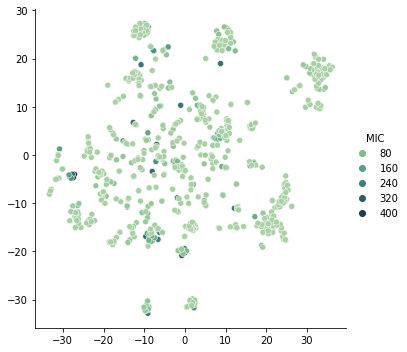

In [66]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

### Protvec

In [67]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

vectors, _ = convert_sequences_to_vectors(df['Sequence'], uniprot_embedding, words_to_vec, kmer=3)
vectors = vectors.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 994.21sequence/s] 


In [68]:
X = tsne.fit_transform(vectors)

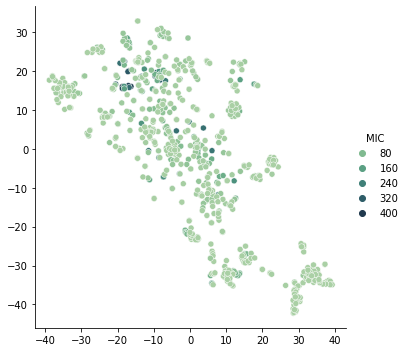

In [69]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

### Averaged Protvec

In [70]:
avg_vectors = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding)
avg_vectors = avg_vectors.reset_index(drop=True)

Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1033.36sequence/s]


In [71]:
X = tsne.fit_transform(avg_vectors)

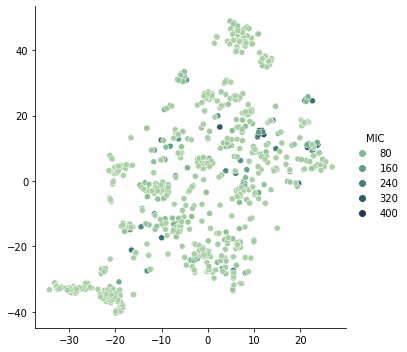

In [72]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

### weighted averaged protvec

In [73]:
kmer_wts = reduce_by_kmer_frequency(df, kmer=3)

In [74]:
wt_avg_vectors = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer_wt=kmer_wts)
# vectors = vectors.reset_index(drop=True)

Creating vectors: 712sequence [00:01, 542.67sequence/s]


In [75]:
X = tsne.fit_transform(wt_avg_vectors)

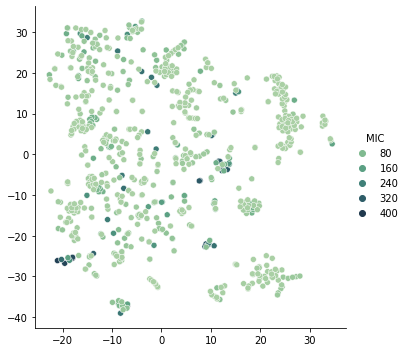

In [76]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

### Physico-chemical properties

In [77]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [78]:
params = ['molecular_weight', 'aromaticity', 'instability_index',
          'isoelectric_point', 'helix', 'turn', 'sheet', 'with_reduced_cysteines',
          'with_disulfid_bridges', 'gravy', 'net_charge_at_pH7point4']

In [79]:
prop = []
for seq in df.Sequence:
    X = ProteinAnalysis(seq)
    molecular_weight = X.molecular_weight()
    aromaticity = X.aromaticity()
    instability_index = X.instability_index()
    isoelectric_point = X.isoelectric_point()
    sec_struc = X.secondary_structure_fraction()
    helix = sec_struc[0]
    turn = sec_struc[1]
    sheet = sec_struc[2]
    epsilon_prot = X.molar_extinction_coefficient()
    with_reduced_cysteines = epsilon_prot[0]
    with_disulfid_bridges = epsilon_prot[1]
    gravy = X.gravy() # hydrophobicity related
    # flexibility = X.flexibility()
    # X.protein_scale()
    net_charge_at_pH7point4 = X.charge_at_pH(7.4)

    prop.append([molecular_weight, aromaticity, instability_index, isoelectric_point, helix, turn, sheet,
                 with_reduced_cysteines, with_disulfid_bridges, gravy, net_charge_at_pH7point4])
prop = pd.DataFrame(prop, columns=params)

In [80]:
X = tsne.fit_transform(prop)

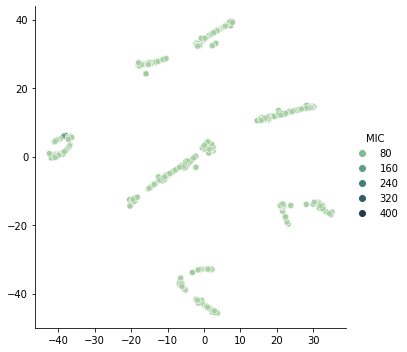

In [81]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
scaler = StandardScaler()
prop_transformed = pd.DataFrame(scaler.fit_transform(prop)).reset_index(drop=True)

In [84]:
X = tsne.fit_transform(prop_transformed)

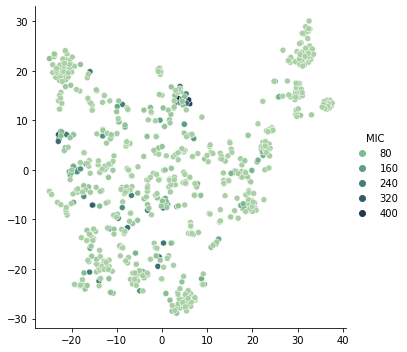

In [85]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

### Physico-chemical properties + averaged protvec

In [86]:
prop_avg_vec = pd.concat([prop, avg_vectors], axis=1)

In [87]:
X = tsne.fit_transform(prop_avg_vec)

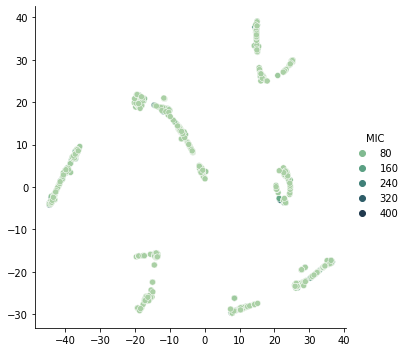

In [88]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

In [89]:
scaler = StandardScaler()
prop_avg_vec_transformed = pd.DataFrame(scaler.fit_transform(prop_avg_vec)).reset_index(drop=True)

In [90]:
X = tsne.fit_transform(prop_avg_vec_transformed)

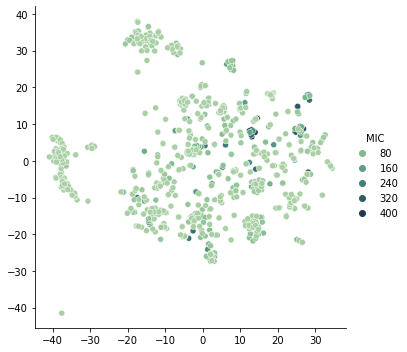

In [91]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

In [92]:
from sklearn.decomposition import PCA

In [93]:
pca = PCA()

In [94]:
prop_avg_vec_pca = pca.fit_transform(prop_avg_vec_transformed)

In [95]:
explained_var_cumsum = np.cumsum(pca.explained_variance_ratio_)

In [96]:
explained_var_cumsum

array([0.17580314, 0.29017987, 0.37194289, 0.45009042, 0.50722186,
       0.55125635, 0.58045534, 0.60858546, 0.63198981, 0.65400033,
       0.67218129, 0.6882707 , 0.70344375, 0.71711998, 0.72974282,
       0.74139137, 0.75167337, 0.76171204, 0.77095123, 0.77985218,
       0.78864275, 0.79653863, 0.80396142, 0.81075851, 0.81729558,
       0.82360488, 0.82957289, 0.83527181, 0.84077437, 0.84610043,
       0.85119568, 0.85607171, 0.86073085, 0.86531446, 0.86980325,
       0.87423506, 0.87845303, 0.88253389, 0.8863794 , 0.89016036,
       0.89379337, 0.89740286, 0.900778  , 0.9040649 , 0.90724412,
       0.91037419, 0.91335478, 0.91627683, 0.91912269, 0.92191802,
       0.92467753, 0.92738301, 0.92988821, 0.9323625 , 0.93476196,
       0.93714054, 0.9394388 , 0.94163218, 0.943806  , 0.94593653,
       0.94798027, 0.95000507, 0.95197833, 0.95386705, 0.95572224,
       0.95752602, 0.95925078, 0.96095971, 0.96262311, 0.96424934,
       0.96582806, 0.96737853, 0.96890346, 0.970374  , 0.97181

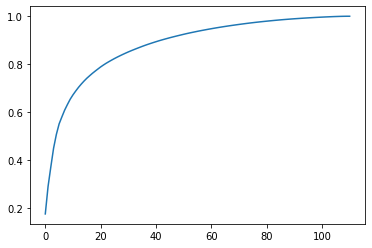

In [97]:
plt.plot(explained_var_cumsum)

In [98]:
X = tsne.fit_transform(prop_avg_vec_pca)

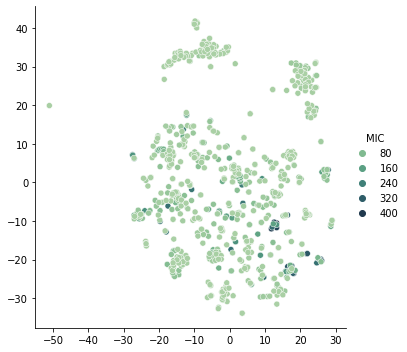

In [99]:
sns.relplot(x=X[:,0], y=X[:,1], palette="ch:r=-.5,l=.75", hue=df['MIC'])

### MIC value distribution

In [ ]:
?sns.kdeplot

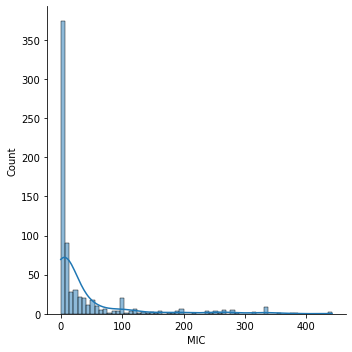

In [23]:
sns.displot(data=df, x='MIC', kde=True)

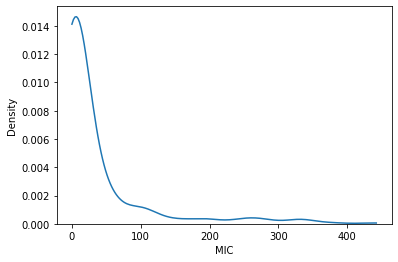

In [24]:
sns.kdeplot(data=df, x='MIC', cut=0)#, kernel='epa')

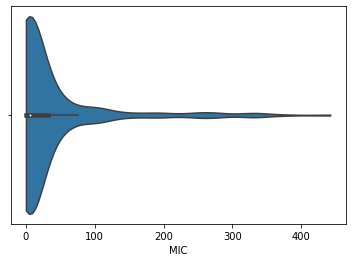

In [100]:
sns.violinplot(data=df, x='MIC', cut=0)

### MIC value transformation

In [101]:
mic_sqrt = np.sqrt(df['MIC'])

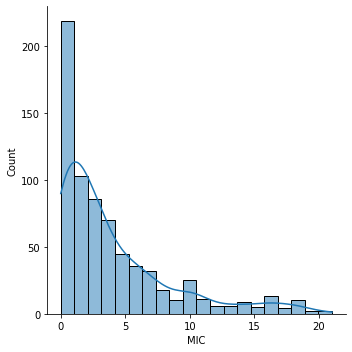

In [102]:
sns.displot(x=mic_sqrt, kde=True)

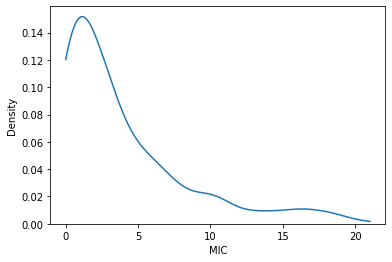

In [103]:
sns.kdeplot(x=mic_sqrt, cut=0)#, kernel='epa')

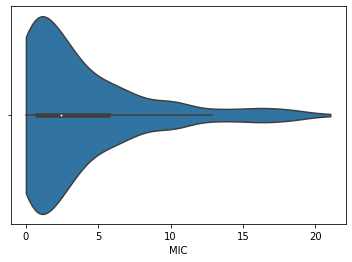

In [104]:
sns.violinplot(x=mic_sqrt, cut=0)

In [105]:
mic_log = np.log(df['MIC'])

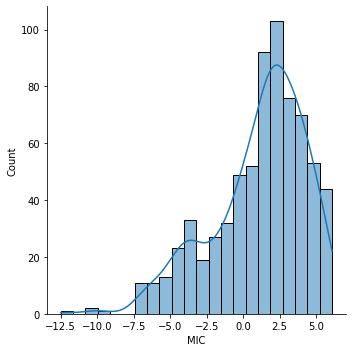

In [106]:
sns.displot(x=mic_log, kde=True)

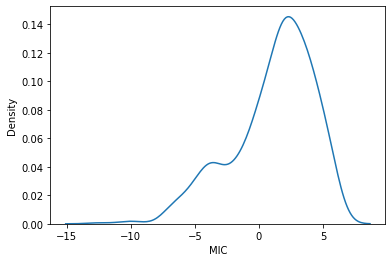

In [107]:
sns.kdeplot(x=mic_log)#, kernel='epa')

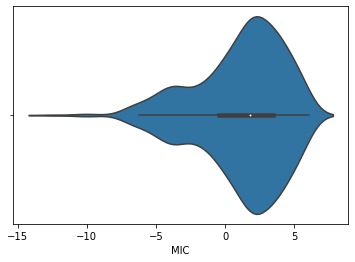

In [108]:
sns.violinplot(x=mic_log)

In [109]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [110]:
mic_boxcox, lmbda = boxcox(df['MIC'])

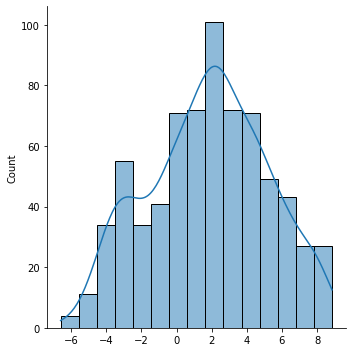

In [111]:
sns.displot(x=mic_boxcox, kde=True)

In [112]:
mic_inv_boxcox = inv_boxcox(mic_boxcox, lmbda)

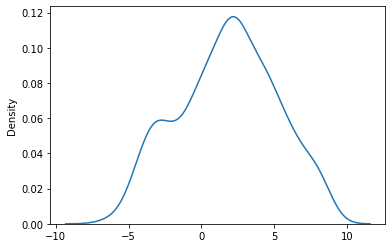

In [113]:
sns.kdeplot(x=mic_boxcox)#, kernel='epa')

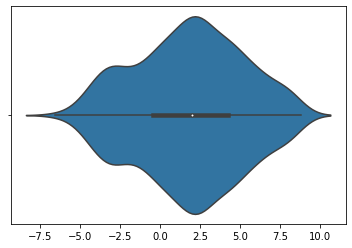

In [114]:
sns.violinplot(x=mic_boxcox)

In [115]:
mic_unif = 1 - np.exp(-lmbda * df['MIC'])

In [116]:
list(zip(df['MIC'],mic_unif))

[(442.0, 1.0),
 (435.5, 1.0),
 (383.0, 1.0),
 (374.0, 1.0),
 (358.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (333.0, 1.0),
 (315.0, 0.9999999999999999),
 (313.0, 0.9999999999999998),
 (285.0, 0.9999999999999956),
 (283.0, 0.9999999999999944),
 (280.0, 0.9999999999999921),
 (280.0, 0.9999999999999921),
 (278.801, 0.9999999999999909),
 (277.0, 0.9999999999999888),
 (266.434, 0.9999999999999617),
 (263.81, 0.9999999999999482),
 (263.0, 0.999999999999943),
 (262.66700000000003, 0.9999999999999408),
 (262.539, 0.9999999999999399),
 (258.33, 0.9999999999999021),
 (250.0, 0.9999999999997428),
 (250.0, 0.9999999999997428),
 (250.0, 0.9999999999997428),
 (245.0, 0.9999999999995407),
 (240.0, 0.9999999999991799),
 (240.0, 0.9999999999991799),
 (237.0, 0.9999999999988386),
 (220.0, 0.9999999999916618),
 (200.0, 0.9999999999152284),
 (200.0, 0.9999999999152284),
 (200.0, 0.9999999999152284),
 (200.0, 0.999999999

In [118]:
np.exp(-36)

2.3195228302435696e-16

(array([201.,  49.,  39.,  33.,  32.,  33.,  36.,  42.,  19., 228.]),
 array([4.29034530e-07, 1.00000386e-01, 2.00000343e-01, 3.00000300e-01,
        4.00000257e-01, 5.00000215e-01, 6.00000172e-01, 7.00000129e-01,
        8.00000086e-01, 9.00000043e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

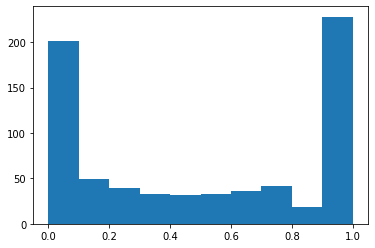

In [119]:
plt.hist(mic_unif)

(array([568.,  49.,  38.,  10.,  12.,  12.,   7.,  11.,   3.,   2.]),
 array([3.70000000e-06, 4.42000033e+01, 8.84000030e+01, 1.32600003e+02,
        1.76800002e+02, 2.21000002e+02, 2.65200001e+02, 3.09400001e+02,
        3.53600001e+02, 3.97800000e+02, 4.42000000e+02]),
 <a list of 10 Patch objects>)

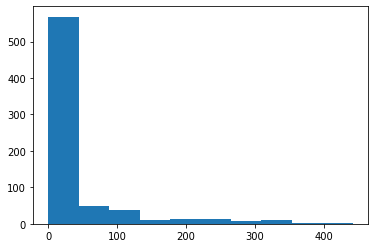

In [120]:
plt.hist(df['MIC'])

In [121]:
mic_unif

0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
707    0.013264
708    0.034188
709    0.001311
710    0.000009
711    0.000232
Name: MIC, Length: 712, dtype: float64

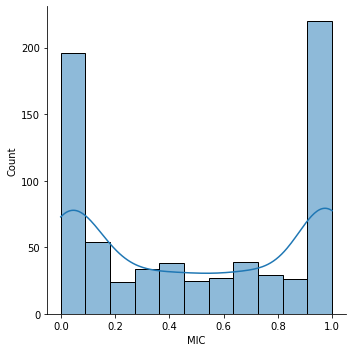

In [122]:
sns.displot(x=mic_unif, kde=True)

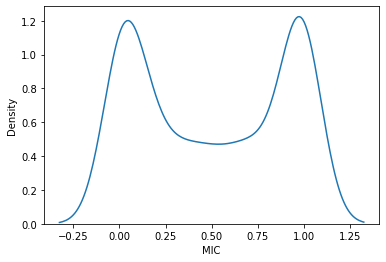

In [123]:
sns.kdeplot(x=mic_unif)#, kernel='epa')

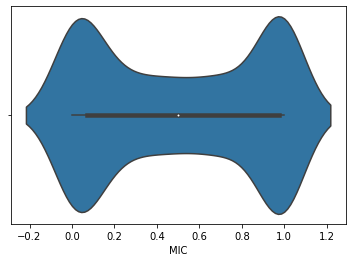

In [124]:
sns.violinplot(x=mic_unif)

In [25]:
from sklearn.preprocessing import StandardScaler

In [26]:
sc = StandardScaler()

In [44]:
mic_ss = (df['MIC']-df['MIC'].mean())/df['MIC'].std()

In [45]:
mic_ss.min()

-0.4952556730972355

In [47]:
mic_ss = mic_ss+0.5

(array([466.,  62.,  40.,  29.,  15.,   5.,  26.,   5.,   7.,   3.,   5.,
          2.,   4.,   7.,   1.,   0.,   7.,   5.,   3.,   4.,   0.,   2.,
          9.,   0.,   1.,   2.,   0.,   0.,   0.,   2.]),
 array([4.74432690e-03, 2.07454628e-01, 4.10164928e-01, 6.12875229e-01,
        8.15585529e-01, 1.01829583e+00, 1.22100613e+00, 1.42371643e+00,
        1.62642673e+00, 1.82913703e+00, 2.03184733e+00, 2.23455763e+00,
        2.43726793e+00, 2.63997823e+00, 2.84268854e+00, 3.04539884e+00,
        3.24810914e+00, 3.45081944e+00, 3.65352974e+00, 3.85624004e+00,
        4.05895034e+00, 4.26166064e+00, 4.46437094e+00, 4.66708124e+00,
        4.86979154e+00, 5.07250184e+00, 5.27521214e+00, 5.47792244e+00,
        5.68063274e+00, 5.88334304e+00, 6.08605334e+00]),
 <a list of 30 Patch objects>)

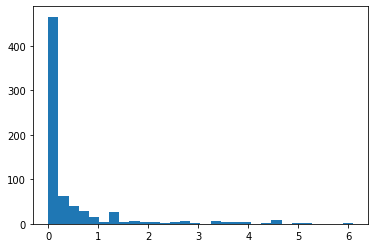

In [135]:
plt.hist(mic_ss, bins=30)

In [49]:
mic_ss_boxcox, lmbda = boxcox(mic_ss)

In [50]:
mic_unif_ss = 1 - np.exp(-lmbda * mic_ss_boxcox)

(array([ 36.,  33.,  56.,  76.,  59.,  99.,  79.,  53.,  60., 161.]),
 array([-0.08485394, -0.05147894, -0.01810394,  0.01527106,  0.04864607,
         0.08202107,  0.11539607,  0.14877108,  0.18214608,  0.21552108,
         0.24889609]),
 <a list of 10 Patch objects>)

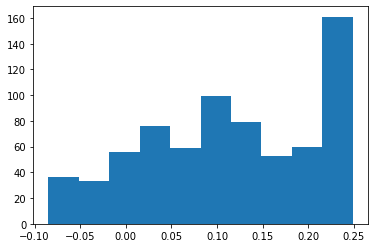

In [51]:
plt.hist(mic_unif_ss)

In [142]:
t = 5

In [144]:
sum(df['MIC'] <= t), sum(df['MIC'] > t)

(343, 369)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a3596b3c8>]],
      dtype=object)

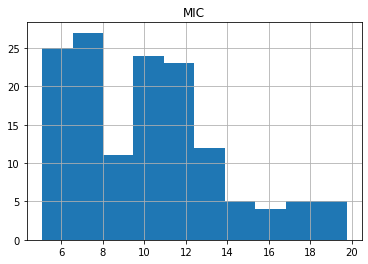

In [147]:
df[(df['MIC'] > 5) & (df['MIC'] < 20)].hist()

In [148]:
df_0_20 = df[df['MIC'] <= 20]

In [137]:
_, lmb = boxcox(df_0_20['MIC'])

In [138]:
df_0_20_unif = 1 - np.exp(-lmb*df_0_20['MIC'])

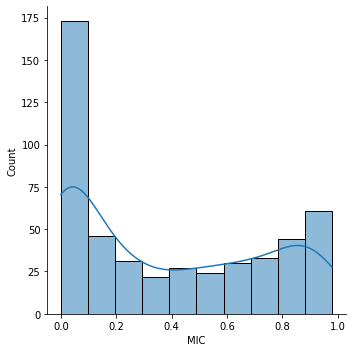

In [139]:
sns.displot(x=df_0_20_unif, kde=True)